# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

*include contributors names here (such as Name1, Name2, ...)* (Group Name)

## General Setup

In [88]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
import sklearn

## Seasonal stats stuff
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocessing, classification, random forest, and cross validation
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [3]:
# Load data

# If you are using Google Colab as Robin does, run the following 4 lines; 
# otherwise, comment them.
# (You might need to make some perturbations on Robin's directory. If so, please 
# comment the line specifying it, and add your line specifying yours)

from google.colab import drive
drive.mount('/content/drive/')
# Robin's directory
d = pd.read_csv('/content/drive/My Drive/Machine-Learning-in-Python-Group-24/Project 2/hotel.csv')

# If you are using Noteable, run the following line.
# d = pd.read_csv("hotel.csv")

Mounted at /content/drive/


In [4]:
d.head()

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1


For the details about data set;

- please check the Project Description pdf file and related article from the Learn page. 

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119390 non-null  int64  
 1   hotel                           119390 non-null  object 
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

There are several columns related to date, we decided to use the number of week because it is easy to interpret and the time interval is not too small to lose the generalizability such as `arrival_date_day_of_month` (besides, this variable should be combined with `arrival_date_month` to make it meaningful), and it is not too large to miss the details such as `arrival_date_month`. Besides, it is better to set `arrival_date_year` and `arrival_date_week_number` as categorical variables because we cannot explain the linear changes within these two variables (and we cannot generalise to the values outside the scope).

In [6]:
d.drop(['arrival_date_month', 'arrival_date_day_of_month'], axis=1, inplace=True)

In [7]:
d.arrival_date_week_number = d.arrival_date_week_number.astype('category')
d.arrival_date_year = d.arrival_date_year.astype('category')

In [8]:
d.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

There are only two kinds of hotel, and we are interested in the cancel rate for two hotel types, so we set it as a categorical variable.

In [9]:
d.hotel = d.hotel.astype('category')

We also set `is_canceled`, `meal`, `market_segment`, `distribution_channel`, `is_repeated_guest`, `reserved_room_type`, `assigned_room_type`, `deposit_type`, `customer_type` as categorical variables for better interpretation.

In [10]:
d.is_canceled = d.is_canceled.astype('category')
d.meal = d.meal.astype('category')
d.market_segment = d.market_segment.astype('category')
d.distribution_channel = d.distribution_channel.astype('category')
d.is_repeated_guest = d.is_repeated_guest.astype('category')
d.reserved_room_type = d.reserved_room_type.astype('category')
d.assigned_room_type = d.assigned_room_type.astype('category')
d.deposit_type = d.deposit_type.astype('category')
d.customer_type = d.customer_type.astype('category')

We want our model to be unbiased and to not be discriminatorey, so we did not include the variable `country`.

In [11]:
d.drop(['country'], axis=1, inplace=True)

For simplicity, we used `previous_cancel_rate` to represent `previous_cancellations` and `previous_bookings_not_canceled`.

In [12]:
d['previous_cancel_rate'] = d.loc[:,['previous_cancellations', 'previous_bookings_not_canceled']]\
                            .apply(lambda x: x[0]/(x[0]+x[1]) if (x[0]+x[1]) != 0 else 0, axis=1)

In [13]:
d.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1, inplace=True)

Checking the columns with N/A in the dataset.

In [14]:
d.columns[d.isna().any()]

Index(['children', 'agent', 'company'], dtype='object')

Now we dealt with N/A values. First are `agent` and `company`, we think that the values with N/A represent individual travelers (making/paying the booking by themselves), and we denote them as 0 and set them as categorical variables (change to `int` first to avoid the float numbers).

In [15]:
d.agent = d.agent.fillna(0)
d.agent = d.agent.astype(int).astype('category')

d.company = d.company.fillna(0)
d.company = d.company.astype(int).astype('category')

After the procedures above, now we only have one column with N/A, `children`. We assumed that it means that there is no children in that booking record, so we set it as 0.

In [16]:
d.children = d.children.fillna(0).astype(int)

In [17]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   is_canceled                  119390 non-null  category
 1   hotel                        119390 non-null  category
 2   lead_time                    119390 non-null  int64   
 3   arrival_date_year            119390 non-null  category
 4   arrival_date_week_number     119390 non-null  category
 5   stays_in_weekend_nights      119390 non-null  int64   
 6   stays_in_week_nights         119390 non-null  int64   
 7   adults                       119390 non-null  int64   
 8   children                     119390 non-null  int64   
 9   babies                       119390 non-null  int64   
 10  meal                         119390 non-null  category
 11  market_segment               119390 non-null  category
 12  distribution_channel         119390 non-null

In [18]:
d.columns

Index(['is_canceled', 'hotel', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'market_segment', 'distribution_channel', 'is_repeated_guest',
       'reserved_room_type', 'assigned_room_type', 'booking_changes',
       'deposit_type', 'agent', 'company', 'days_in_waiting_list',
       'customer_type', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'previous_cancel_rate'],
      dtype='object')

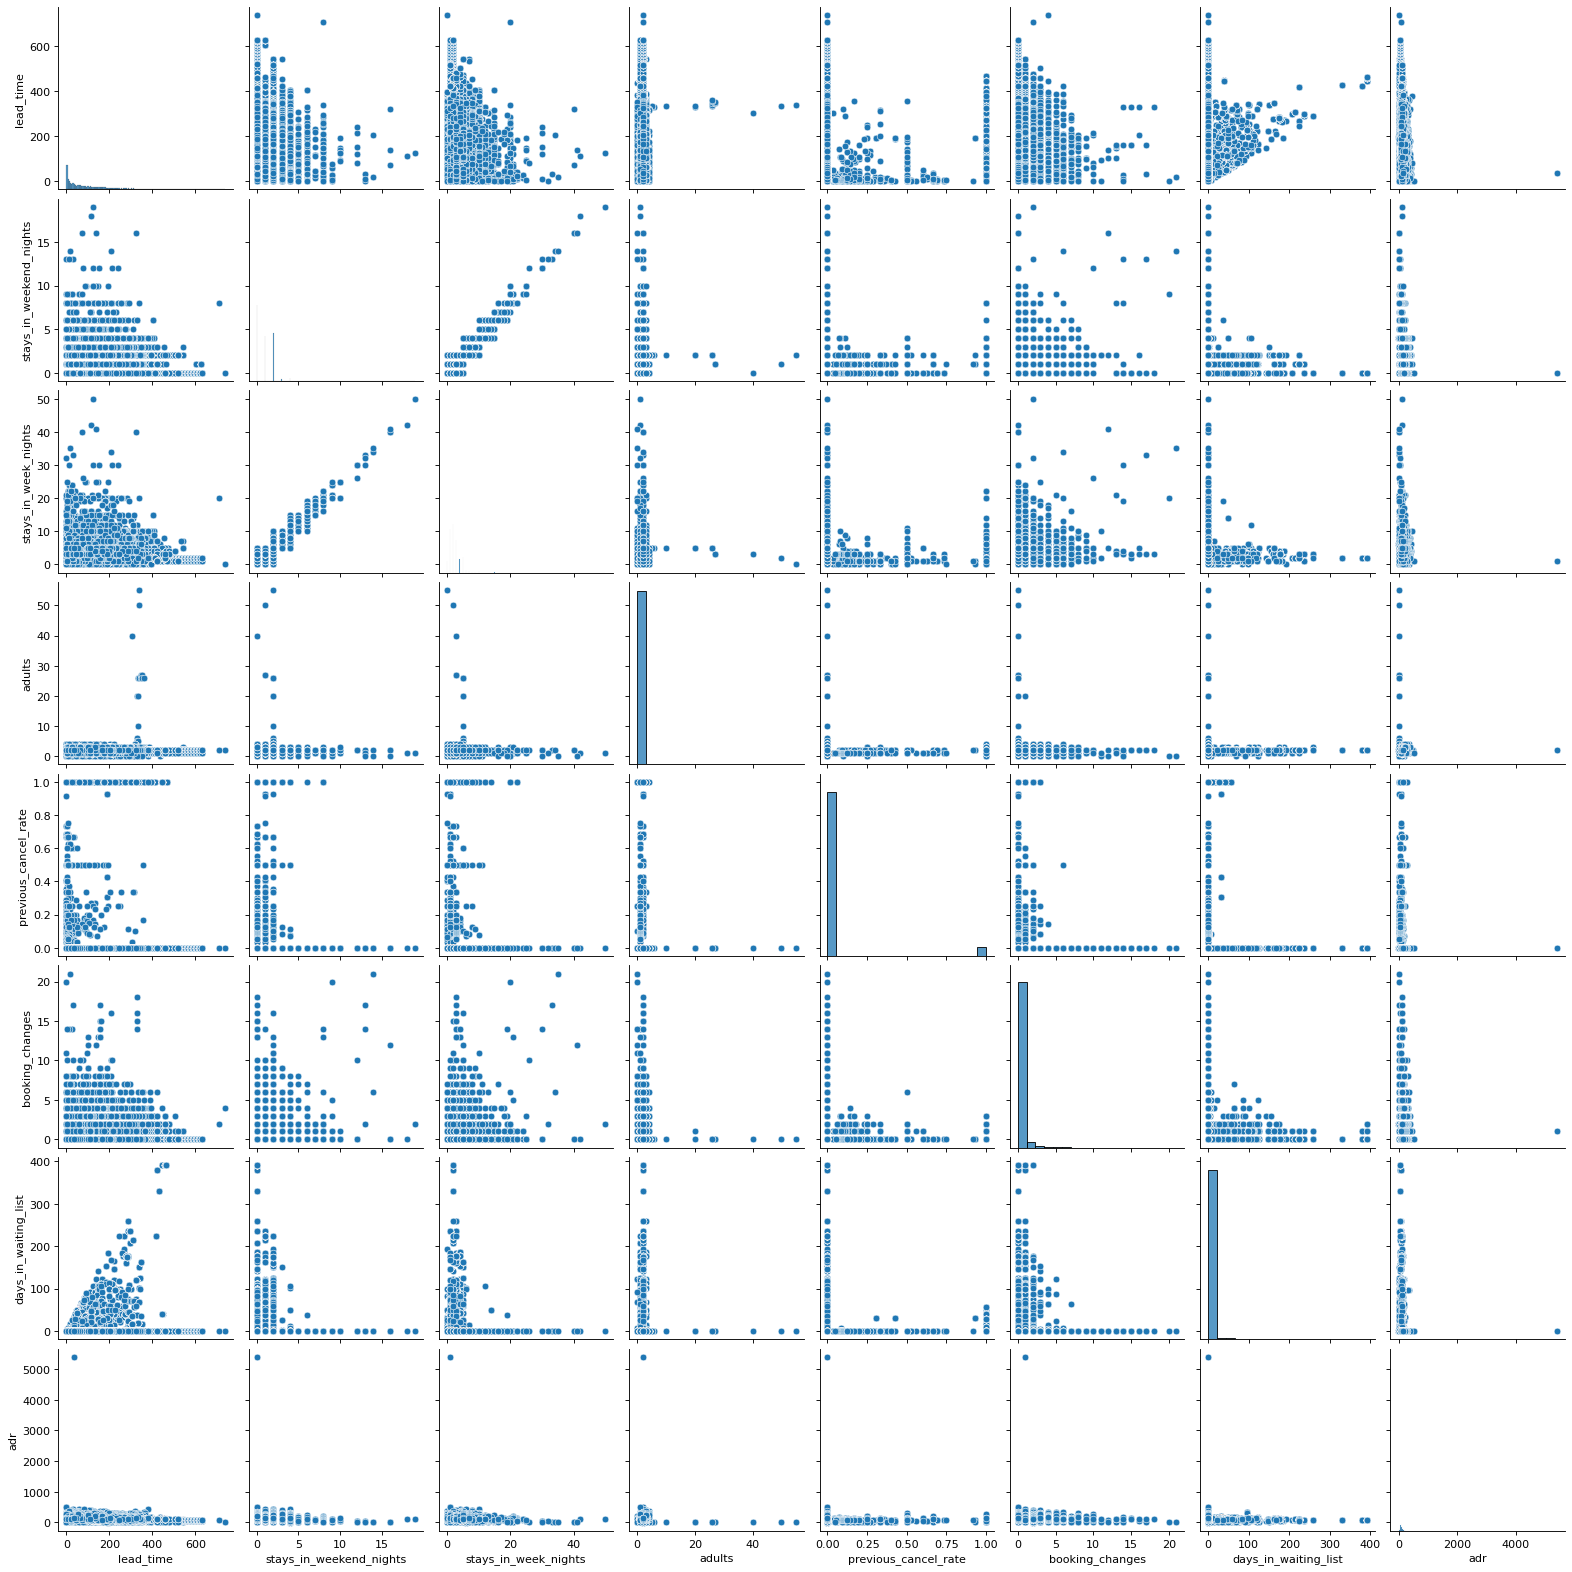

In [19]:
sns.pairplot(data = d.loc[:, ['hotel', 'lead_time',
       'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'meal', 'previous_cancel_rate', 
       'booking_changes', 'days_in_waiting_list', 'adr']])

Some highly correlated variables: `stays_in_weekend_nights` & `stays_in_week_nights`, `days_in_waiting_list` & `lead_time`, `lead_time` & `booking_changes`, `stays_in_weekend_nights` & `booking_changes`, `stays_in_week_nights` & `booking_changes`, `booking_changes` & `days_in_waiting_list`, `booking_changes` & `previous_cancel_rate`. 

Now we will make a pairplot, using `is_canceled` for the `hue` argument, so check for relationships with cancelations.

In [20]:
# sns.pairplot(data = d.loc[:, ['is_canceled', 'hotel', 'lead_time',
#        'stays_in_weekend_nights',
#        'stays_in_week_nights', 'adults', 'meal', 'previous_cancel_rate', 
#        'booking_changes', 'days_in_waiting_list', 'adr']], hue = 'is_canceled')

Distribution of all variables looks similar for cancelled and not cancelled. There seem to be correlations between `adr` & `lead_time` & `is_canceled`, `lead_time` & `previous_cancel_rate` & `is_canceled`, `lead_time` & `days_in_waiting_list` & `is_canceled`.

There are no obvious data transformations that need to occur for the variables.

[Text(0.5, 1.0, 'Cancelation Rate by Week, Year'),
 Text(0.5, 0, 'Week Number'),
 Text(0, 0.5, 'Cancellation rate')]

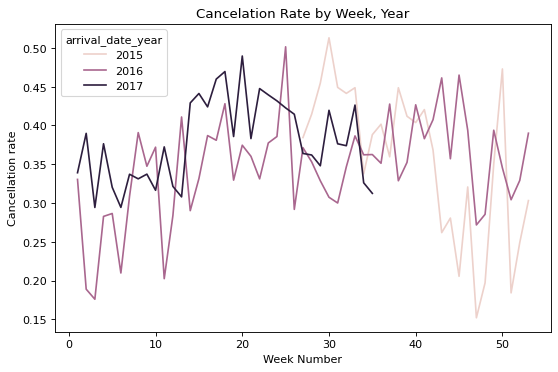

In [21]:
## Make sum of cancelled/not cancelled by week number and year, plot the line plot!
temp = d.copy()
temp.is_canceled = d.is_canceled.astype(int)
temp.arrival_date_year = d.arrival_date_year.astype(int)
temp.arrival_date_week_number = d.arrival_date_week_number.astype(int)


count_cancel = temp.groupby(by = ['arrival_date_year', 'arrival_date_week_number'], 
                            as_index = False).mean()

sns.lineplot(data = count_cancel, x = "arrival_date_week_number", y = "is_canceled", 
             hue = "arrival_date_year").set(title = "Cancelation Rate by Week, Year", 
                                            xlabel = "Week Number", ylabel = "Cancellation rate")


2015: data collection begins approximately halfway through the year. There are sharp fluctuations in the data, with an overall decreasing trend in the cancelation rate.

2016: The cancelation rate has strong fluctuations, however at the start of the year the rate is low relative to later in the year.

2017: data collection ends roughly halfway through the year. There are sharp fluctuations in the data, but there is a slight increase in the cancelation rate with time, followed by a slight decrease near the end of the data.

I will calculate the rolling average for the cancel rate to smooth the data, then look for more trends.

[Text(0.5, 1.0, 'Rolling Average Cancel Rate'),
 Text(0, 0.5, 'Rolling Average Cancel Rate'),
 Text(0.5, 0, 'Week Number')]

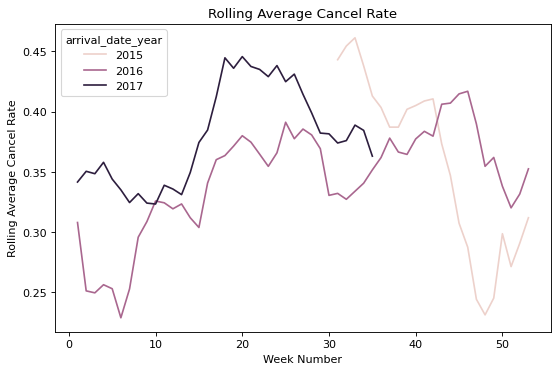

In [22]:
count_cancel["cancel_rate_ma"] = count_cancel["is_canceled"].rolling(window = 5).mean()

sns.lineplot(data = count_cancel, x = "arrival_date_week_number", 
             y = "cancel_rate_ma", hue = "arrival_date_year").set(title = "Rolling Average Cancel Rate", 
                                                                  ylabel = "Rolling Average Cancel Rate", 
                                                                  xlabel = "Week Number")

2015: Data begins approximately halfway through the year. There is an initial increase in the cancelation rate, which peaks at week 40, and then declines until the end of the year.

2016: There seem to be 2 peaks to the cancelation rate: at approximately week 20, and week 45. This suggests seasonality. The cancelation rate is lowest at the begining of the year, and the trend is to lower again at the end of the year.

2017: data ends approximately halfway through the year. Cancellation rate increases form the begining of the year to a peak at approximately week 20, then declines until data collection ends.

It may be worth it to model for seasonality in our data.

From the plot it looks like roughly week 45 to week 10 should be one season, week 10 to week 25 should be another season, week 25 to week 35 should be a season, and the remaining weeks should be another season. 

To choose the dummy variables from the seasons: 

Start by getting a rough idea of the outer bands of the end points of the seasons - a peak and a trough should be included in this band.

Find the max value of both years in the peak, find the average date of those two points. Find the min value for both years in the band, compute the average week between those two weeks (if the average week is a decimal round to the week to the nearest integer). 

** Use the rolling averages because they are robust against outliers/extreme values **

Find the average of the values between those two dates - this is the end/begining point of a season.

Repeat until you have 4 seasons.

Turn that into dummy variables. 

In [23]:
## Seasonal point 1: week 1 to week 22
## Years 2017 and 2016

min2017 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2017)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2016)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016min)
print(week2017min)

max2017 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2017)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_week_number"] < 22) & (count_cancel["arrival_date_year"] == 2016)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016max)
print(week2017max)
print((8 + 20)/2)

sea_point1 = 14


32    6
Name: arrival_date_week_number, dtype: int64
89    10
Name: arrival_date_week_number, dtype: int64
46    20
Name: arrival_date_week_number, dtype: int64
99    20
Name: arrival_date_week_number, dtype: int64
14.0


In [24]:
## Seasonal point 2: week 20 to end of 2017 (35)
## Use 2016 and 2017 only due to lack of overlap with 2015

#count_cancel.loc[count_cancel["arrival_date_year"] == 2017].arrival_date_week_number.max()

min2017 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2017) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016min)
print(week2017min)

max2017 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2017) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 35) & (count_cancel["arrival_date_week_number"] > 20)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2017max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2017) & (count_cancel["arrival_date_year"] == 2017)]["arrival_date_week_number"]

print(week2016max)
print(week2017max)

print((31.5 + 24.5)/2)
sea_point2 = 28

58    32
Name: arrival_date_week_number, dtype: int64
110    31
Name: arrival_date_week_number, dtype: int64
51    25
Name: arrival_date_week_number, dtype: int64
103    24
Name: arrival_date_week_number, dtype: int64
28.0


In [25]:
count_cancel.loc[count_cancel["arrival_date_year"] == 2015].head()

,arrival_date_year,arrival_date_week_number,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,previous_cancel_rate,cancel_rate_ma
0,2015,27,0.384401,152.481894,0.938719,3.030641,1.927577,0.050139,0.005571,0.142061,0.0,88.979749,0.064067,0.415042,0.245822,NaN
1,2015,28,0.414433,127.995876,1.303093,3.173196,1.971134,0.111340,0.016495,0.154639,0.0,92.682701,0.101031,0.534021,0.237113,NaN
2,2015,29,0.454545,129.861472,1.069264,2.643579,1.940837,0.088023,0.008658,0.155844,0.0,100.624791,0.076479,0.389610,0.283670,NaN
3,2015,30,0.512987,120.985714,1.045455,2.588312,1.961039,0.098701,0.009091,0.148052,0.0,97.159675,0.064935,0.354545,0.324675,NaN
4,2015,31,0.449050,103.917098,1.245250,2.937824,1.958549,0.146805,0.005181,0.167530,0.0,113.428325,0.089810,0.618307,0.203800,0.443083


In [26]:
## Seasonal point 3: week 31 to 43

min2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016min)
print(week2015min)

max2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 43) & (count_cancel["arrival_date_week_number"] > 31)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016max)
print(week2015max)

print((35 + 37)/2)

sea_point3 = 36

58    32
Name: arrival_date_week_number, dtype: int64
11    38
Name: arrival_date_week_number, dtype: int64
67    41
Name: arrival_date_week_number, dtype: int64
6    33
Name: arrival_date_week_number, dtype: int64
36.0


In [27]:
## Seasonal point 4: week 37 to the end (53)
## Years 2016 and 2015

#count_cancel["arrival_date_week_number"].max()

min2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.min()
min2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.min()

week2016min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015min = count_cancel.loc[(count_cancel["cancel_rate_ma"] == min2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016min)
print(week2015min)

max2015 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2015) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.max()
max2016 = count_cancel.loc[(count_cancel["arrival_date_year"] == 2016) & (count_cancel["arrival_date_week_number"] < 53) & (count_cancel["arrival_date_week_number"] > 37)].cancel_rate_ma.max()

week2016max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2016) & (count_cancel["arrival_date_year"] == 2016)]["arrival_date_week_number"]
week2015max = count_cancel.loc[(count_cancel["cancel_rate_ma"] == max2015) & (count_cancel["arrival_date_year"] == 2015)]["arrival_date_week_number"]

print(week2016max)
print(week2015max)

print((51 + 48 + 46 + 42)/4)

sea_point4 = 47

77    51
Name: arrival_date_week_number, dtype: int64
21    48
Name: arrival_date_week_number, dtype: int64
72    46
Name: arrival_date_week_number, dtype: int64
15    42
Name: arrival_date_week_number, dtype: int64
46.75


In [28]:
d.arrival_date_week_number = d.arrival_date_week_number.astype(int)


In [29]:
d["season"] = 0

d.loc[d["arrival_date_week_number"] < sea_point1, "season"] = 1
d.loc[d["arrival_date_week_number"] >= sea_point4, "season"] = 1
d.loc[(d["arrival_date_week_number"] >= sea_point1) & (d["arrival_date_week_number"] < sea_point2), "season"] = 2
d.loc[(d["arrival_date_week_number"] >= sea_point2) & (d["arrival_date_week_number"] < sea_point3), "season"] = 3
d.loc[(d["arrival_date_week_number"] >= sea_point3) & (d["arrival_date_week_number"] < sea_point4), "season"] = 4

d.season = d.season.astype("category")
d.arrival_date_week_number = d.arrival_date_week_number.astype("category")
d.head()

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,previous_cancel_rate,season
0,0,Resort Hotel,342,2015,27,0,0,2,0,0,...,No Deposit,0,0,0,Transient,0.0,0,0,0.0,2
1,0,Resort Hotel,737,2015,27,0,0,2,0,0,...,No Deposit,0,0,0,Transient,0.0,0,0,0.0,2
2,0,Resort Hotel,7,2015,27,0,1,1,0,0,...,No Deposit,0,0,0,Transient,75.0,0,0,0.0,2
3,0,Resort Hotel,13,2015,27,0,1,1,0,0,...,No Deposit,304,0,0,Transient,75.0,0,0,0.0,2
4,0,Resort Hotel,14,2015,27,0,2,2,0,0,...,No Deposit,240,0,0,Transient,98.0,0,1,0.0,2


In [30]:
temp_count_cancel = count_cancel.dropna(axis=0).reset_index()
temp_count_cancel.index = pd.date_range("20150727", periods=111, freq="W")

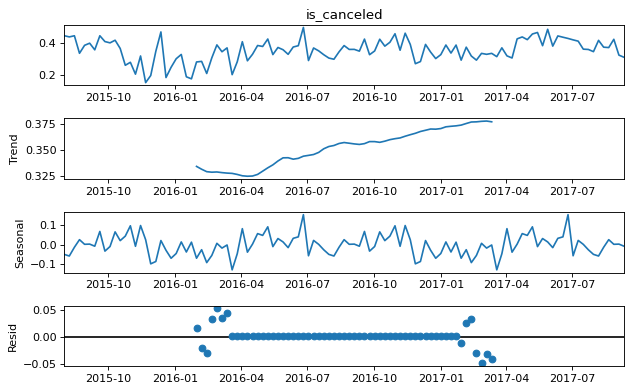

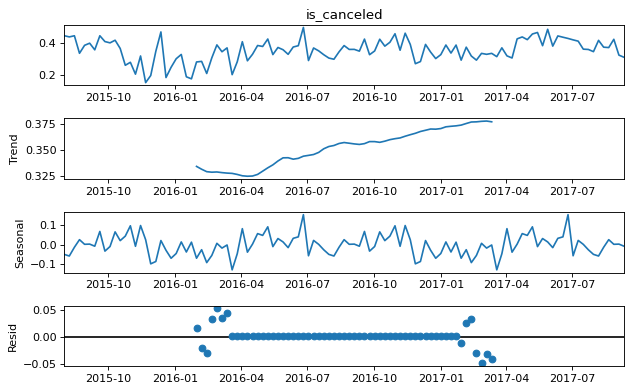

In [31]:
results = seasonal_decompose(temp_count_cancel.is_canceled)
results.plot()

In [32]:
results.seasonal

2015-08-02   -0.048704
2015-08-09   -0.057093
2015-08-16   -0.012341
2015-08-23    0.026554
2015-08-30    0.002850
                ...   
2017-08-13   -0.012341
2017-08-20    0.026554
2017-08-27    0.002850
2017-09-03    0.003848
2017-09-10   -0.006895
Freq: W-SUN, Name: seasonal, Length: 111, dtype: float64

[Text(0.5, 1.0, 'Number of Cancellations by Week, Year'),
 Text(0.5, 0, 'Week Number'),
 Text(0, 0.5, 'Number of Cancelations')]

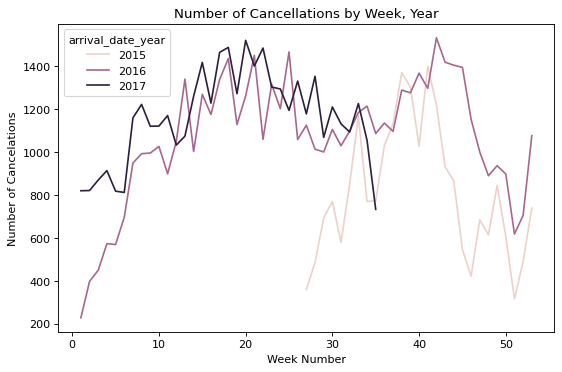

In [33]:
count_cancel = temp.groupby(by = ['arrival_date_year', 'arrival_date_week_number'], 
                            as_index = False).count()

sns.lineplot(data = count_cancel, x = "arrival_date_week_number", y = "is_canceled", 
             hue = "arrival_date_year").set(title = "Number of Cancellations by Week, Year", 
                                            xlabel = "Week Number", ylabel = "Number of Cancelations")

2015: data start approximately halfway through the year. Initially very few cancelations, cancelations peak around week 40, cancelations decrease again toward the end of the year. Data show similar trend as 2016.

2016: Very few cancelations at the begining of the year, cancelations increase until aproximately week 20, where they decline slightly, then peak again at week 40, then decline until the end of the year. Possible evidence of seasonality.

2017: Data goes until about halfway through the year. Data show similar trend as in 2016, with higher initial cancelations.

There is evidence of seasonality in our data, it may be worth it to create seaonal dummy variables to include for consideration in our model.

[Text(0.5, 1.0, 'Rolling Average Cancel Rate'),
 Text(0, 0.5, 'Rolling Average Cancel Rate'),
 Text(0.5, 0, 'Week Number')]

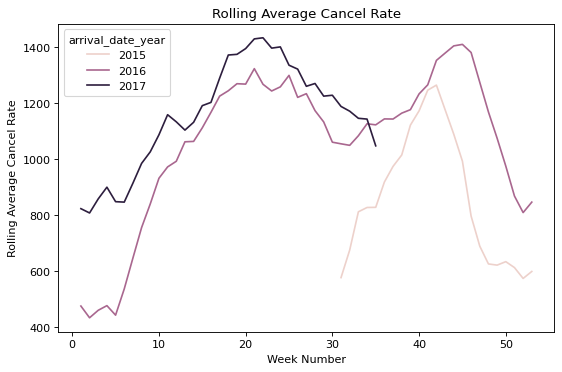

In [34]:
count_cancel["cancel_rate_ma"] = count_cancel["is_canceled"].rolling(window = 5).mean()

sns.lineplot(data = count_cancel, x = "arrival_date_week_number", 
             y = "cancel_rate_ma", hue = "arrival_date_year").set(title = "Rolling Average Cancel Rate", 
                                                                  ylabel = "Rolling Average Cancel Rate", xlabel = "Week Number")

In the plot smoothed by the rolling data the seasonality in the absolute value of cancellations looks quite clear. It is hard to analyse the dip between the two peaks in cancelations because of the lack of overlap with 2016 and one specific year (half the observations which are not from 2016 for this time of the year come from 2017, and other half from 2015).

In [35]:
temp_count_cancel = count_cancel.dropna(axis=0).reset_index()
temp_count_cancel.index = pd.date_range("20150727", periods=111, freq="W")

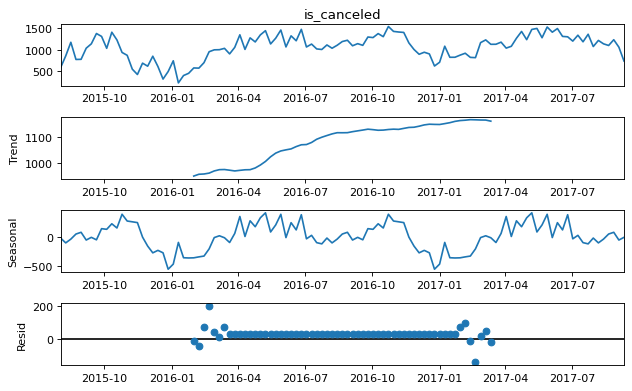

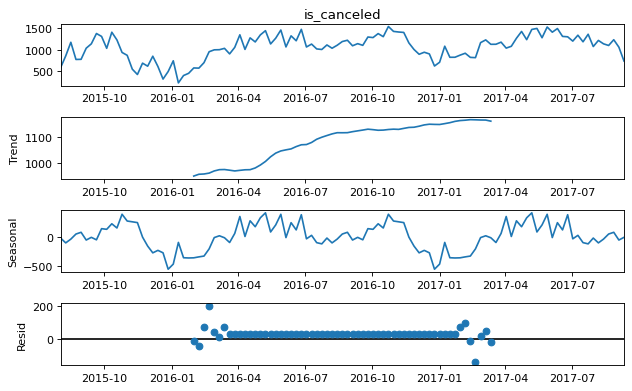

In [36]:
results = seasonal_decompose(temp_count_cancel.is_canceled)
results.plot()

The seasonal trend is clearer in the absolute count data, it may make more sense to create the season categories based on this data than the cancellation rate.

Now we visualise the categorical data using barplots.

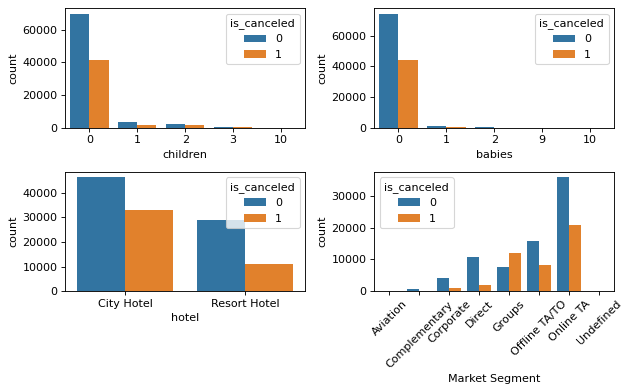

In [37]:
fig, axs = plt.subplots(ncols=2, nrows = 2)

plt.xticks(rotation = 45)

sns.countplot(x = d["children"], hue = d["is_canceled"], ax = axs[0, 0])
sns.countplot(x = d["babies"], hue = d["is_canceled"], ax = axs[0, 1])
sns.countplot(x = d["hotel"], hue = d["is_canceled"], ax = axs[1, 0])
sns.countplot(x = d["market_segment"], hue = d["is_canceled"], ax = axs[1, 1]).set(xlabel = "Market Segment")

plt.tight_layout()

Number of children does not seem to have a relationship with cancelation, neither do babies. City hotels seem to have a higher proportion of cancelations compared to resort hotels. The group market segment has the highest proportion of cancelations - there are more cancelations than not canceled bookings in this group.

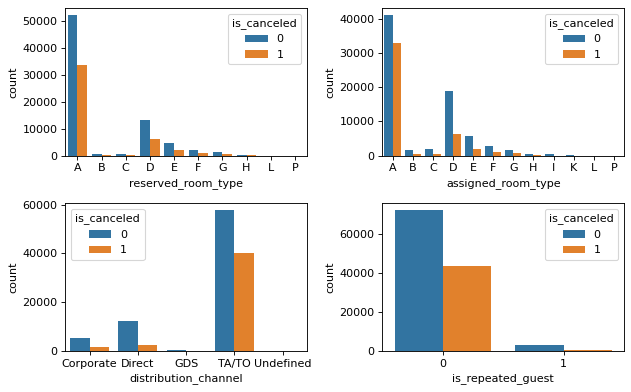

In [38]:
fig, axs = plt.subplots(ncols=2, nrows = 2)

sns.countplot(x = d["distribution_channel"], hue = d["is_canceled"], ax = axs[1, 0])
sns.countplot(x = d["is_repeated_guest"], hue = d["is_canceled"], ax = axs[1, 1])
sns.countplot(x = d["reserved_room_type"], hue = d["is_canceled"], ax = axs[0, 0])
sns.countplot(x = d["assigned_room_type"], hue = d["is_canceled"], ax = axs[0, 1])

plt.tight_layout()

Received room type does not seem to have an impact on cancelations, neither does reserved room type. Distribution channel does not seem to have a large effect, and neither does repeated guest status. 

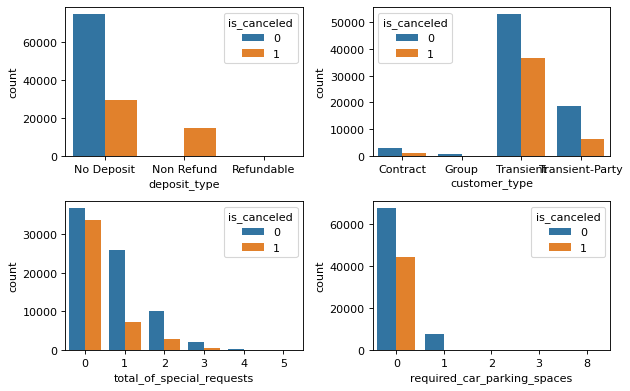

In [39]:
fig, axs = plt.subplots(ncols=2, nrows = 2)

sns.countplot(x = d["deposit_type"], hue = d["is_canceled"], ax = axs[0, 0])
sns.countplot(x = d["customer_type"], hue = d["is_canceled"], ax = axs[0, 1])
sns.countplot(x = d["total_of_special_requests"], hue = d["is_canceled"], ax = axs[1, 0])
sns.countplot(x = d["required_car_parking_spaces"], hue = d["is_canceled"], ax = axs[1, 1])

plt.tight_layout()

The non refund deposit type has the highest proportion of cancellations, which is unexpected. Almost all observations in this group are canceled (14,494 cancellations out of 14,587 observations total with this type). Transient customer type has the highest proportion of cancellations - these are the cancellations booked not as part of a group or contract. 0 required car parking spaces has the highest proportion of cancellations - however this may be because there are significantly fewer bookings where customers require any car parking spaces. The highest proportion of cancellations by far comes from customers with 0 special requests - which again may be due to the fact that this is the largest group in the special requests category. 

In [40]:
print(d.loc[d["deposit_type"] == "Non Refund"]["is_canceled"].astype(int).sum())
d.loc[d["deposit_type"] == "Non Refund"].shape
#d.deposit_type.unique()

14494


(14587, 27)

<Axes: xlabel='season', ylabel='count'>

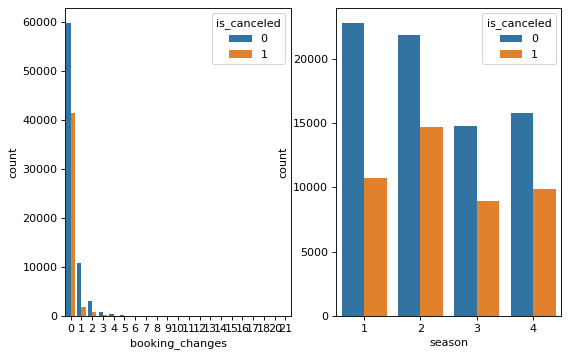

In [41]:
fig, axs = plt.subplots(ncols=2)

sns.countplot(x = d["booking_changes"], hue = d["is_canceled"], ax = axs[0])
sns.countplot(x = d["season"], hue = d["is_canceled"], ax = axs[1])

The proportion of cancellations is lowest in season 1. Season 2 seems to have the highest proportion of cancellations. Seasons 3 and 4 show the least distinction in proportion of cancelations, which is understandable because they were the shortest seasons, and also didn't appear to differ a lot in the rolling averages plot - the main reason to keep them distinct was because some of the data would have only been from 2016 and 2017, and some of the data would have only been from 2016 and 2015, so the overlap was an issue for determining the season. Bookings with no booking changes has the highest proportion of cancellations, which again may be due to the fact that it is by far the largest group. 

In [42]:
## Create a variable which is 1 if reserved room type is the same as assigned room type, see if it has an impact.

d_copy = d.copy()
d_copy.reserved_room_type = d.reserved_room_type.cat.codes
d_copy.assigned_room_type = d.assigned_room_type.cat.codes

d["reserved_matches_assigned"] = np.where((d_copy["reserved_room_type"] == d_copy["assigned_room_type"]), 1, 0)
d["reserved_matches_assigned"] = d["reserved_matches_assigned"].astype("category")

<Axes: xlabel='reserved_matches_assigned', ylabel='count'>

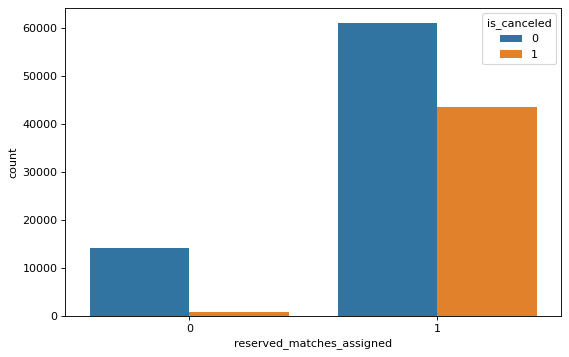

In [43]:
sns.countplot(x = d["reserved_matches_assigned"], hue = d["is_canceled"])

A significantly higher proportion of rooms where the reserved room matches the assigned room are cancelled - this is likely because the majority of rooms assigned match those reserved.

## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a logistic regression model, a classification tree, and a SVC model and ultimately settled on the logistic regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the logistic regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

-------------------------------------------------------------------

Some of the variables in the dataset are needed to be transformed into the correct numeric format.

In [77]:
number = preprocessing.LabelEncoder()
d['hotel'] = number.fit_transform(d['hotel'])
d['meal'] = number.fit_transform(d['meal'])
d['market_segment'] = number.fit_transform(d['market_segment'])
d['distribution_channel'] = number.fit_transform(d['distribution_channel'])
d['reserved_room_type'] = number.fit_transform(d['reserved_room_type'])
d['assigned_room_type'] = number.fit_transform(d['assigned_room_type'])
d['deposit_type'] = number.fit_transform(d['deposit_type'])
d['customer_type'] = number.fit_transform(d['customer_type'])

Datasets are then being separated, and random forest is selected in our classification.

In [97]:
# Splits the dataset into training and testing sets
X = d.loc[:, d.columns != 'is.canceled']
y = d.is_canceled
X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = RandomForestClassifier(max_depth = 2, random_state = 0)

param_grid = { 
    'n_estimators': [100],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4],
    'criterion' :['gini', 'entropy']
}

rsh = GridSearchCV(
    estimator = clf, param_grid = param_grid, cv = 10
)
rsh.fit(X_train, y_train)
rsh.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 100}

## 4. Discussion & Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

Your report must include the following:

* Some discussion of the features that are most important for predicting a cancelation - we do not need discussion of specific coefficient values but direction of the effect should be clear (e.g. the earlier a booking is made the more likely it is to be canceled).

* A validated assessment of your model's performance, but this must be specifically discussed in the context of bookings and running a hotel. 

* It is not sufficient to report summary statistics like the accuracy or AUC - you must address the perfomance in terms of potential gains and losses for the hotel (e.g. think about what happens if your model predicts a cancelation that does not actually occur and a room ends up being double booked or vice versa). 

* Explain why you think your particular model would or would not be economically viable.

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from